# Clasificacion de comandos de voz

https://blog.research.google/2017/08/launching-speech-commands-dataset.html



In [1]:
from librosa import load, resample
from librosa.feature import mfcc as MFCC_lr
from librosa.feature import delta as DELTA_lr
import librosa
import numpy as np
import matplotlib.pyplot       as plt

In [26]:
#load audio file with a fixed duration, append zeros or truncate
def loadFixLength(entry,duration=3.6):
    #work to 16kHz
    new_fs = 16000
    s, fs = load(entry,sr=None)
    if (len(s.shape) !=1):    # raise error if more than one channel
        s=s[:,0]
    if (fs!=new_fs):
        s = resample(s,orig_sr=fs, target_sr=new_fs)
    s = s - s.mean()
    fs=new_fs    
    max_d = int(fs*duration)
    tempData = np.zeros( max_d) 
    if(s.size < max_d):
        tempData[:s.size] = s
    else:
        tempData = s[:max_d]    
    return tempData,fs 
########################## get melspectrogram
def melspec_lr(s,fs,hop_length=100,win_length=400,n_mels=27,n_fft=512):
        #s   = librosa.effects.preemphasis(s)
        S    = librosa.feature.melspectrogram(y=s, sr=fs, n_fft=n_fft, hop_length=hop_length, win_length=win_length,n_mels=n_mels)
        feats = librosa.power_to_db(S, ref=np.max) 
        feats_norm = ((feats.T - feats.mean(axis=1))/(feats.std(axis=1)+np.finfo(float).eps)).T
        return feats_norm  
########################## get mfcc
def mfcc_lr(s,fs,n_mfcc=13,hop_length=100,win_length=400):
        mfccs = MFCC_lr(y=s, sr=fs, n_mfcc=n_mfcc,hop_length=hop_length, win_length=win_length,htk=True)
        mfcc_delta = DELTA_lr(mfccs)
        mfcc_delta2 = DELTA_lr(mfccs, order=2)
        #concat all features
        feats= np.vstack((mfccs,mfcc_delta,mfcc_delta2)) + np.finfo(float).eps
        #feats=feats.T;
        feats_norm = ((feats.T - feats.mean(axis=1))/(feats.std(axis=1)+np.finfo(float).eps)).T
        return feats_norm   
########################## convert to image [0-255]
def toImage(feature):
        spec_min, spec_max = feature.min(), feature.max()
        feature_scaled = 255 * (feature - spec_min) / (spec_max - spec_min)
        feature_scaled = feature_scaled.astype(np.uint8)
        return feature_scaled

In [27]:
from glob import glob
data_dir = "speechCommands/*"
audioPaths  = glob(data_dir,recursive=True)
clases = [x.split('\\')[1] for x in audioPaths]
clases

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

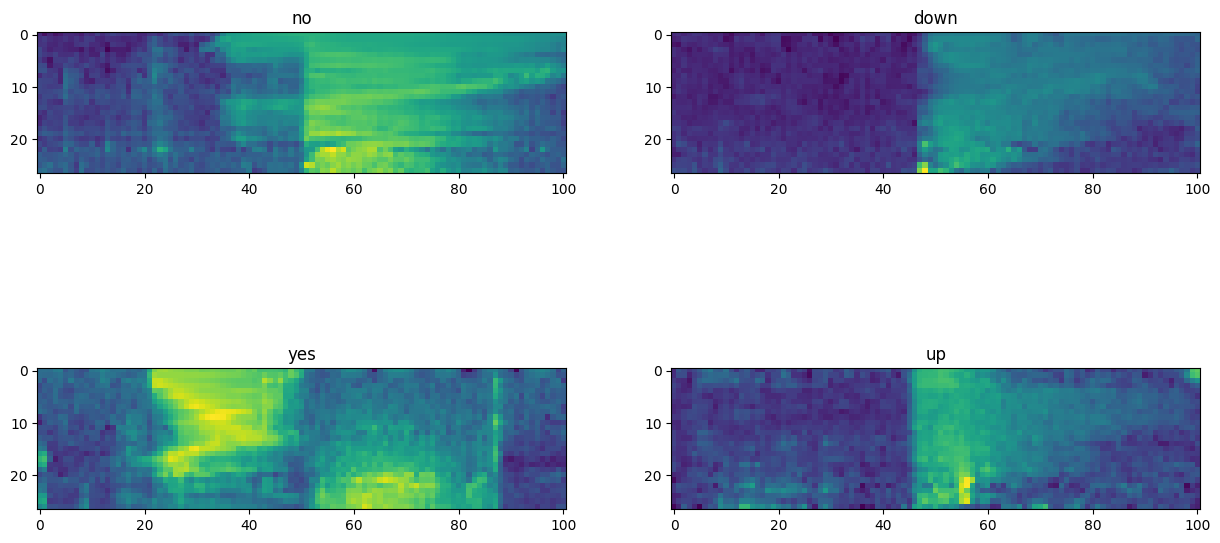

In [29]:
examples=["speechCommands/no/0a9f9af7_nohash_0.wav",
"speechCommands/down/00b01445_nohash_0.wav",
"speechCommands/yes/00f0204f_nohash_0.wav",
"speechCommands/up/00b01445_nohash_0.wav"]
plt.figure(figsize=(15, 8)) 

for i, entry in enumerate(examples):
    s, fs = loadFixLength(entry,1)
    win_length = int(0.025*fs)
    hop_length = int(0.01*fs)
    n_fft      = 512
    n_mels     = 27
    n_mfcc     = 13
    melspec = melspec_lr(s,fs,hop_length,win_length,n_mels)  
    mfcc    = mfcc_lr(s,fs,n_mfcc,hop_length,win_length)
    img     = toImage(melspec)
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    clase = entry.split('/')[1]
    plt.title(clase)

In [24]:
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

## leer todos los archivos
data_dir = "speechCommands/"
filesC1 = glob(data_dir+"yes/*.wav", recursive=True)
filesC2 = glob(data_dir+"no/*.wav", recursive=True)
filesC3 = glob(data_dir+"up/*.wav", recursive=True)
filesC4 = glob(data_dir+"down/*.wav", recursive=True)
filesAudio = filesC1+filesC2+filesC3+filesC4
clases = ["yes","no","up","down"]
filesCount = [len(filesC1),len(filesC2),len(filesC3),len(filesC4)]
print("[INFO]: clases y conteo por clase:",clases,filesCount)
frames = []
labels = []
for file_name in tqdm(filesAudio):  
    s, fs = loadFixLength(entry,1)
    win_length = int(0.025*fs)
    hop_length = int(0.01*fs)
    n_fft      = 512
    n_mels     = 27
    n_mfcc     = 13
    melspec = melspec_lr(s,fs,hop_length,win_length,n_mels)  
    #mfcc    = mfcc_lr(s,fs,n_mfcc,hop_length,win_length)
    img     = toImage(melspec)
    frames.append(img)
    file_name = file_name.replace("\\",'/') #para windows
    clase     = file_name.split('/')[1]
    labels.append(clase)
frames=np.array(frames)

#organizar los labels: one hot encoding
le = LabelBinarizer()
labels = le.fit_transform(labels)

print(f"[INFO] base de datos: frames {frames.shape}")

[INFO]: clases y conteo por clase: ['yes', 'no', 'up', 'down'] [2377, 2375, 2375, 2359]


100%|█████████████████████████████████████████████████████████████████████████████| 9486/9486 [00:33<00:00, 280.93it/s]

[INFO] base de datos: frames (9486, 27, 101)


In [25]:
labels

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])